# Lab assignment №1, part 2

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the second part of the assignment. First and third parts are waiting for you in the same directory.*__

## Part 2. Data preprocessing, model training and evaluation.

### 1. Reading the data
Today we work with the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), describing different cars for multiclass ($k=4$) classification problem. The data is available below.

In [1]:
# If on colab, uncomment the following lines

# ! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_made/homeworks/lab01_ml_pipeline/car_data.csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize

from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA

import xgboost as xgb

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [49]:
dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

print(data.shape, target.shape)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(846, 19) (846,)
(549, 19) (549,) (297, 19) (297,)


To get some insights about the dataset, `pandas` might be used. The `train` part is transformed to `pd.DataFrame` below.

In [50]:
X_train_pd = pd.DataFrame(X_train)

# First 15 rows of our dataset.
X_train_pd.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,528,95,47,73,195,70,7,167,38,20,152,184,430,185,69,9,19,200,206
1,226,107,54,98,210,66,11,218,31,24,169,221,704,216,71,14,0,188,197
2,31,88,42,77,151,58,8,140,47,18,142,165,293,158,64,10,11,198,205
3,361,101,46,105,195,61,10,198,34,23,150,213,578,195,66,7,38,192,205
4,372,97,47,87,164,64,9,156,43,20,149,173,359,182,68,1,13,192,202
5,495,94,45,72,179,69,6,156,41,19,144,181,373,191,69,5,5,193,198
6,285,89,48,85,189,64,8,169,39,20,153,188,427,190,64,16,5,195,201
7,329,89,38,80,169,59,7,161,41,20,131,186,389,137,68,5,15,192,197
8,774,94,37,72,146,60,9,133,50,18,135,161,262,128,69,2,7,192,195
9,116,100,45,100,209,65,8,201,32,23,147,231,611,189,72,5,5,189,195


Methods `describe` and `info` deliver some useful information.

In [51]:
X_train_pd.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.00000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,422.792350,93.828780,44.941712,82.147541,168.945355,61.539162,8.393443,169.249545,40.872495,20.612022,148.224044,188.75592,442.499089,175.429872,72.342441,6.156648,12.453552,189.016393,195.734062
std,242.739551,8.206494,6.249107,15.949684,33.073419,7.062082,3.910265,33.758611,7.857893,2.628577,14.489705,31.80751,180.392563,33.505489,7.444885,4.811886,9.019046,6.198194,7.601764
min,1.000000,76.000000,33.000000,40.000000,110.000000,47.000000,2.000000,112.000000,26.000000,17.000000,119.000000,130.00000,184.000000,109.000000,59.000000,0.000000,0.000000,176.000000,181.000000
25%,215.000000,88.000000,40.000000,70.000000,140.000000,57.000000,7.000000,146.000000,33.000000,19.000000,137.000000,167.00000,318.000000,150.000000,67.000000,2.000000,5.000000,185.000000,190.000000
50%,416.000000,93.000000,44.000000,80.000000,167.000000,61.000000,8.000000,156.000000,43.000000,20.000000,146.000000,177.00000,363.000000,174.000000,71.000000,5.000000,11.000000,189.000000,197.000000
75%,635.000000,100.000000,50.000000,98.000000,197.000000,65.000000,10.000000,200.000000,46.000000,23.000000,161.000000,217.00000,600.000000,199.000000,75.000000,9.000000,19.000000,193.000000,201.000000
max,845.000000,119.000000,59.000000,112.000000,306.000000,126.000000,52.000000,265.000000,61.000000,29.000000,186.000000,288.00000,1018.000000,268.000000,127.000000,22.000000,40.000000,204.000000,211.000000


In [52]:
X_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       549 non-null    int64
 1   1       549 non-null    int64
 2   2       549 non-null    int64
 3   3       549 non-null    int64
 4   4       549 non-null    int64
 5   5       549 non-null    int64
 6   6       549 non-null    int64
 7   7       549 non-null    int64
 8   8       549 non-null    int64
 9   9       549 non-null    int64
 10  10      549 non-null    int64
 11  11      549 non-null    int64
 12  12      549 non-null    int64
 13  13      549 non-null    int64
 14  14      549 non-null    int64
 15  15      549 non-null    int64
 16  16      549 non-null    int64
 17  17      549 non-null    int64
 18  18      549 non-null    int64
dtypes: int64(19)
memory usage: 81.6 KB


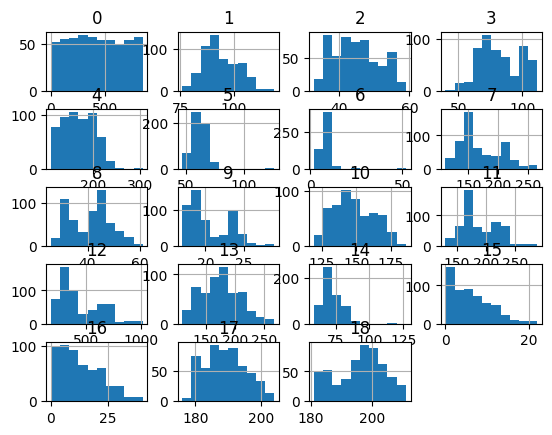

In [53]:
X_train_pd.hist();

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((549, 19), (297, 19), (549,), (297,))

In [55]:
np.unique(y_train, return_counts=True)  # датасет сбалансирован

(array(['bus', 'opel', 'saab', 'van'], dtype=object),
 array([145, 129, 146, 129]))

### 2. Machine Learning pipeline
Here you are supposed to perform the desired transformations. Please, explain your results briefly after each task.

#### 2.0. Data preprocessing
* Make some transformations of the dataset (if necessary). Briefly explain the transformations

In [56]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [57]:
# по гистограммам и describe() видно, что распределения многих переменных похожи на нормальную, 
# конечно, можно по отдельности обработать каждое переменное, но датасет небольшой и это не особо будет влиять на результат, 
# так что можно просто взять стандартную нормировку
sc = StandardScaler()
x_train_sc = sc.fit_transform(X_train)
x_test_sc = sc.transform(X_test)

#### 2.1. Basic logistic regression
* Find optimal hyperparameters for logistic regression with cross-validation on the `train` data (small grid/random search is enough, no need to find the *best* parameters).

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` `tol=1e-3` and ` max_iter=500`.*

In [72]:
lr = LogisticRegression(multi_class='multinomial', 
                        solver='saga', 
                        tol=1e-3, 
                        max_iter=500, 
                        random_state=0)
param_grid = {'C': [0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50, 100, 150, 200], 
              'penalty': ['l2', 'l1', 'elasticnet']}

grid = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(x_train_sc, y_train_le)

best_lr = grid.best_estimator_
best_lr_params = grid.best_params_

Fitting 5 folds for each of 39 candidates, totalling 195 fits


In [73]:
y_pred_tr = best_lr.predict(x_train_sc)
y_pred = best_lr.predict(x_test_sc)
y_proba = best_lr.predict_proba(x_test_sc)

acc_tr = accuracy_score(y_train_le, y_pred_tr)
acc = accuracy_score(y_test_le, y_pred)
f1m = f1_score(y_test_le, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_le, y_proba, multi_class='ovr')

In [74]:
print("Best params:", grid.best_params_)
print(f"Train accuracy: {acc_tr:.3f}, Test accuracy: {acc:.3f}, F1_macro: {f1m:.3f}, ROC-AUC: {roc_auc:.3f}")

Best params: {'C': 100, 'penalty': 'l1'}
Train accuracy: 0.829, Test accuracy: 0.811, F1_macro: 0.817, ROC-AUC: 0.951


In [75]:
def plot_roc_curve(y_true, y_probs, class_labels=None):
    n_classes = y_probs.shape[1]
    
    if class_labels is None:
        class_labels = [f"Class {i}" for i in range(n_classes)]

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle="--", color="k")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

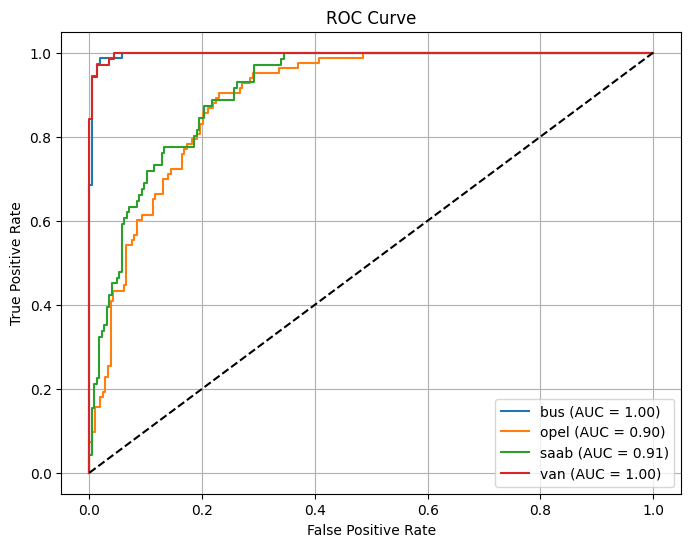

In [76]:
plot_roc_curve(y_test_le, y_proba, class_labels=le.classes_)

Лучшие параметры получил 'C'=100, 'penalty'='l1' (кросс-валидация - 5-fold).

На тестовой выборке:
- accuracy = 0.811
- macro f1_score = 0.817
- ROC-AUC = 0.951
- roc_curve (график нарисован выше)

In [63]:
# You might use this command to install scikit-plot. 
# Warning, if you a running locally, don't call pip from within jupyter, call it from terminal in the corresponding 
# virtual environment instead

# ! pip install scikit-plot

#### 2.2. PCA: explained variance plot
* Apply the PCA to the train part of the data. Build the explaided variance plot. 

In [64]:
pca = PCA()
pca.fit(x_train_sc)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [65]:
exp_var = pca.explained_variance_ratio_
exp_var

array([5.00836343e-01, 1.63745526e-01, 8.91989460e-02, 6.35494853e-02,
       5.04618249e-02, 4.61747387e-02, 3.16784945e-02, 2.03346869e-02,
       1.11146318e-02, 8.30255720e-03, 4.58524999e-03, 3.07575466e-03,
       2.27728551e-03, 1.74759922e-03, 1.09206932e-03, 8.18624771e-04,
       6.78491067e-04, 3.10659658e-04, 1.70317208e-05])

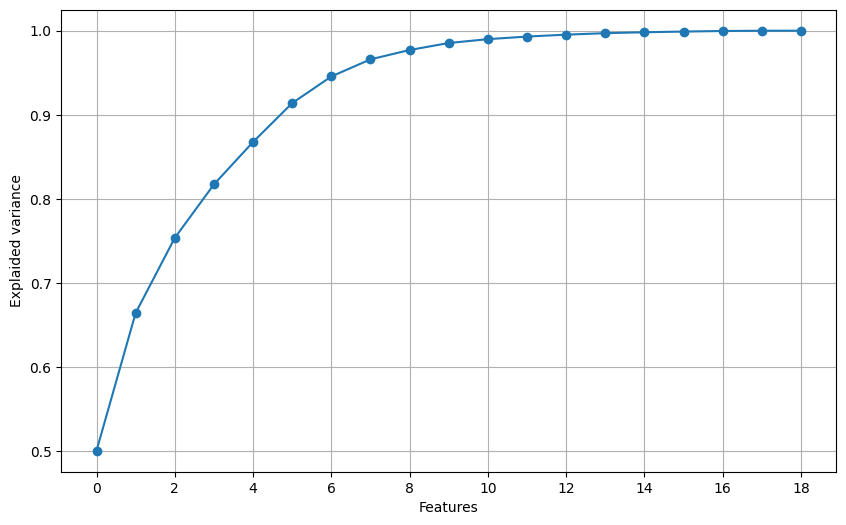

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(exp_var), marker="o")
plt.xlabel('Features')
plt.ylabel('Explaided variance')
plt.xticks(np.arange(0, 19, 2))
plt.grid();

Больше 95% дисперсии достигается при 7 компонентам. 

#### 2.3. PCA trasformation
* Select the appropriate number of components. Briefly explain your choice. Should you normalize the data?

*Use `fit` and `transform` methods to transform the `train` and `test` parts.*

In [67]:
pca = PCA(n_components=7)
x_train_pca = pca.fit_transform(x_train_sc)
x_test_pca = pca.transform(x_test_sc)

**Note: From this point `sklearn` [Pipeline](https://scikit-learn.org/stable/modules/compose.html) might be useful to perform transformations on the data. Refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for more information.**

#### 2.4. Logistic regression on PCA-preprocessed data.
* Find optimal hyperparameters for logistic regression with cross-validation on the transformed by PCA `train` data.

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` and `tol=1e-3`*

In [68]:
lr = LogisticRegression(multi_class='multinomial', 
                        solver='saga', 
                        tol=1e-3, 
                        random_state=0)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 2, 3, 5, 10, 20, 50], 
              'penalty': ['l2', 'l1', 'elasticnet', None]}

grid = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(x_train_pca, y_train_le)

best_lr = grid.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [69]:
y_pred_tr = best_lr.predict(x_train_pca)
y_pred = best_lr.predict(x_test_pca)
y_proba = best_lr.predict_proba(x_test_pca)

acc_tr = accuracy_score(y_train_le, y_pred_tr)
acc = accuracy_score(y_test_le, y_pred)
f1m = f1_score(y_test_le, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_le, y_proba, multi_class='ovr')

In [70]:
print("Best params:", grid.best_params_)
print(f"Train accuracy: {acc_tr:.3f}, Test accuracy: {acc:.3f}, F1_macro: {f1m:.3f}, ROC-AUC: {roc_auc:.3f}")

Best params: {'C': 0.1, 'penalty': 'l1'}
Train accuracy: 0.632, Test accuracy: 0.593, F1_macro: 0.576, ROC-AUC: 0.833


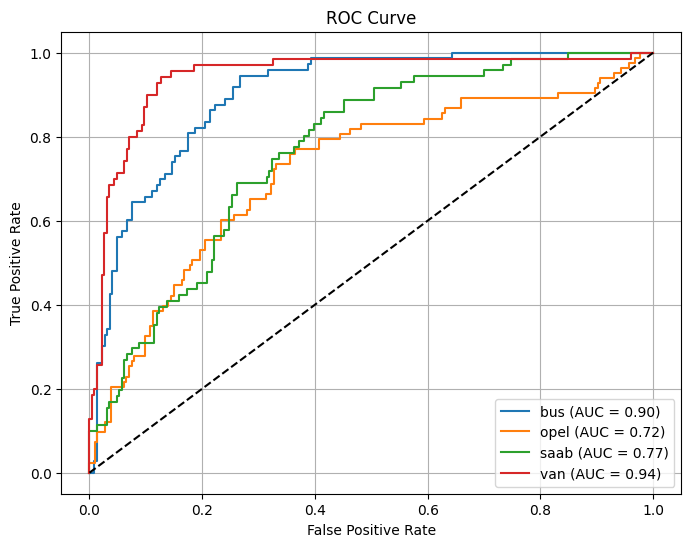

In [71]:
plot_roc_curve(y_test_le, y_proba, class_labels=le.classes_)

Лучшие параметры получил 'C'=0.1, 'penalty'='l1' (кросс-валидация - 5-fold).

На тестовой выборке получил:
- accuracy = 0.593
- macro f1_score = 0.576
- ROC-AUC = 0.833
- roc_curve (график нарисован выше)

Очевидно, качество модели упало.

#### 2.5. Decision tree
* Now train a desicion tree on the same data. Find optimal tree depth (`max_depth`) using cross-validation.

* Measure the model quality using the same metrics you used above.

In [77]:
dt = DecisionTreeClassifier(random_state=0)
param_grid = {"max_depth": range(3, 21),
              "min_samples_split": range(2, 11),
              "min_samples_leaf": range(1, 11),
              "criterion": ["gini", "entropy"],
             }

grid = GridSearchCV(dt, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train_le)

best_tree = grid.best_estimator_
best_tree_params = grid.best_params_

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


In [78]:
y_pred_tr = best_tree.predict(X_train)
y_pred = best_tree.predict(X_test)
y_proba = best_tree.predict_proba(X_test)

acc_tr = accuracy_score(y_train_le, y_pred_tr)
acc = accuracy_score(y_test_le, y_pred)
f1m = f1_score(y_test_le, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_le, y_proba, multi_class='ovr')

In [79]:
print("Best params:", grid.best_params_)
print(f"Train accuracy: {acc_tr:.3f}, Test accuracy: {acc:.3f}, F1_macro: {f1m:.3f}, ROC-AUC: {roc_auc:.3f}")

Best params: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10}
Train accuracy: 0.865, Test accuracy: 0.687, F1_macro: 0.680, ROC-AUC: 0.848


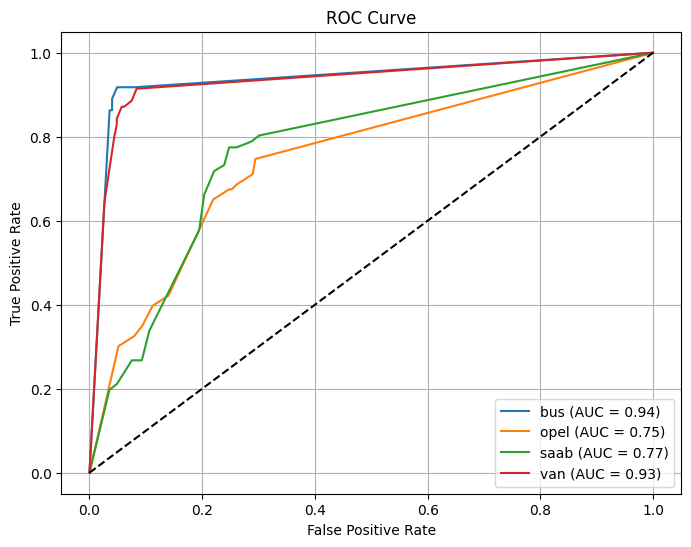

In [80]:
plot_roc_curve(y_test_le, y_proba, class_labels=le.classes_)

Лучшие параметры получил (кросс-валидация - 5-fold)
- criterion = entropy
- max_depth = 8
- min_samples_leaf = 2
- min_samples_split = 10

На тестовой выборке получил:
- accuracy = 0.687
- macro f1_score = 0.680
- ROC-AUC = 0.848
- roc_curve (график нарисован выше), график получился не очень информативным, потому что модел Decision Tree не находит вероятности

Тут особо не важен выборка нормализован или нет. Оба варианта дали одинаковый результат.

Модель переобучена (на тренировочной выборке accuracy больше, чем на тестовой выборке), но если попытаться избавиться от переобучения, снижая max_depth или увеличивая min_samples_leaf или min_samples_split, то качество модели на тестовой выборке тоже сильно снижается.

#### 2.6. Bagging.
Here starts the ensembling part.

First we will use the __Bagging__ approach. Build an ensemble of $N$ algorithms varying N from $N_{min}=2$ to $N_{max}=100$ (with step 5).

We will build two ensembles: of logistic regressions and of decision trees.

*Comment: each ensemble should be constructed from models of the same family, so logistic regressions should not be mixed up with decision trees.*


*Hint 1: To build a __Bagging__ ensebmle varying the ensemble size efficiently you might generate $N_{max}$ subsets of `train` data (of the same size as the original dataset) using bootstrap procedure once. Then you train a new instance of logistic regression/decision tree with optimal hyperparameters you estimated before on each subset (so you train it from scratch). Finally, to get an ensemble of $N$ models you average the $N$ out of $N_{max}$ models predictions.*

*Hint 2: sklearn might help you with this taks. Some appropriate function/class might be out there.*

* Plot `f1` and `accuracy` scores plots w.r.t. the size of the ensemble.

* Briefly analyse the plot. What is the optimal number of algorithms? Explain your answer.

* How do you think, are the hyperparameters for the decision trees you found in 2.5 optimal for trees used in ensemble? 

In [81]:
logreg_base = LogisticRegression(**best_lr_params,
                                 multi_class='multinomial',
                                 solver='saga',
                                 tol=1e-3,
                                 max_iter=500,
                                 random_state=0
                                )

ensemble_sizes = np.arange(2, 101, 5)
acc_scores_lr_train = []
acc_scores_lr_test = []
f1_scores_lr_train = []
f1_scores_lr_test = []

for n in tqdm(ensemble_sizes):
    bag_lr = BaggingClassifier(estimator=logreg_base, n_estimators=n, random_state=1, n_jobs=-1)
    bag_lr.fit(x_train_sc, y_train_le)
    
    y_pred_bag_lr_tr = bag_lr.predict(x_train_sc)
    y_pred_bag_lr_te = bag_lr.predict(x_test_sc)
    
    acc_scores_lr_train.append(accuracy_score(y_train_le, y_pred_bag_lr_tr))
    acc_scores_lr_test.append(accuracy_score(y_test_le, y_pred_bag_lr_te))
    
    f1_scores_lr_train.append(f1_score(y_train_le, y_pred_bag_lr_tr, average='macro'))
    f1_scores_lr_test.append(f1_score(y_test_le, y_pred_bag_lr_te, average='macro'))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.74s/it]


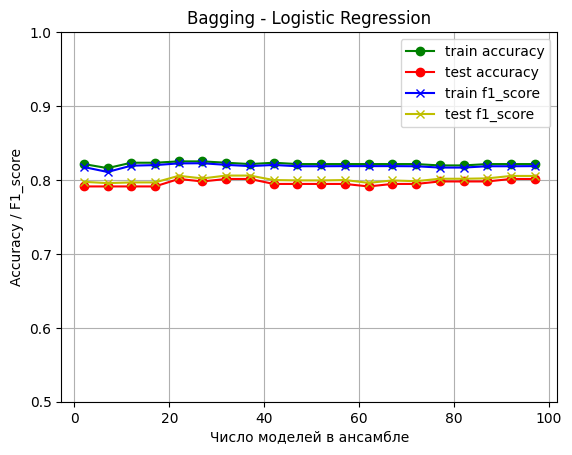

In [82]:
plt.plot(ensemble_sizes, acc_scores_lr_train, marker='o', label="train accuracy", c="g")
plt.plot(ensemble_sizes, acc_scores_lr_test, marker='o', label="test accuracy", c="r")
plt.plot(ensemble_sizes, f1_scores_lr_train, marker='x', label="train f1_score", c="b")
plt.plot(ensemble_sizes, f1_scores_lr_test, marker='x', label="test f1_score", c="y")
plt.title('Bagging - Logistic Regression')
plt.xlabel('Число моделей в ансамбле')
plt.ylabel('Accuracy / F1_score')
plt.ylim((0.5, 1))
plt.legend()
plt.grid();

In [83]:
dt_base = DecisionTreeClassifier(**best_tree_params,
                                 random_state=0
                                )

ensemble_sizes = np.arange(2, 101, 5)
acc_scores_dt_train = []
acc_scores_dt_test = []
f1_scores_dt_train = []
f1_scores_dt_test = []

for n in tqdm(ensemble_sizes):
    bag_dt = BaggingClassifier(estimator=dt_base, n_estimators=n, random_state=1, n_jobs=-1)
    bag_dt.fit(x_train_sc, y_train_le)
    
    y_pred_bag_dt_tr = bag_dt.predict(x_train_sc)
    y_pred_bag_dt_te = bag_dt.predict(x_test_sc)
    
    acc_scores_dt_train.append(accuracy_score(y_train_le, y_pred_bag_dt_tr))
    acc_scores_dt_test.append(accuracy_score(y_test_le, y_pred_bag_dt_te))
    
    f1_scores_dt_train.append(f1_score(y_train_le, y_pred_bag_dt_tr, average='macro'))
    f1_scores_dt_test.append(f1_score(y_test_le, y_pred_bag_dt_te, average='macro'))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.84it/s]


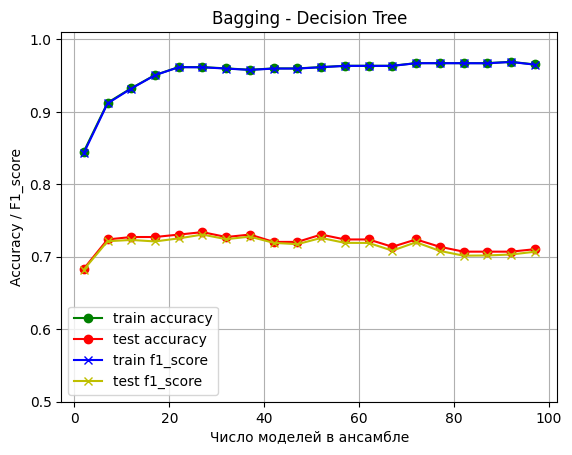

In [84]:
plt.plot(ensemble_sizes, acc_scores_dt_train, marker='o', label="train accuracy", c="g")
plt.plot(ensemble_sizes, acc_scores_dt_test, marker='o', label="test accuracy", c="r")
plt.plot(ensemble_sizes, f1_scores_dt_train, marker='x', label="train f1_score", c="b", )
plt.plot(ensemble_sizes, f1_scores_dt_test, marker='x', label="test f1_score", c="y")
plt.title('Bagging - Decision Tree')
plt.xlabel('Число моделей в ансамбле')
plt.ylabel('Accuracy / F1_score')
plt.ylim((0.5, 1.01))
plt.legend()
plt.grid();

In [85]:
ensemble_sizes[np.where(np.array(acc_scores_lr_test) == max(acc_scores_lr_test))], max(acc_scores_lr_test)

(array([22, 32, 37, 92, 97]), 0.8013468013468014)

In [86]:
ensemble_sizes[np.where(np.array(acc_scores_dt_test) == max(acc_scores_dt_test))], max(acc_scores_dt_test)

(array([27]), 0.734006734006734)

При Logistic regression максимальный accuracy получилось при количество моделей 22, 32, 37, 92, 97 (accuracy = 0.801).

При Decision Tree максимальный accuracy получилось при количество деревьев 27 (accuracy = 0.734). Но модели с деревьями сильно переобучалась (видно на графике). Причина в том, что в ансамблевых моделях обично выбирают недообученные модели, чтобы в совокупности дали хороший результат, а тут у нас каждое дерево переобучалось, а в итоге общий результат стал сильно переобученным (accuracy на train почти равен 1).

#### 2.7. Random Forest
Now we will work with the Random Forest (its `sklearn` implementation).

* * Plot `f1` and `accuracy` scores plots w.r.t. the number of trees in Random Forest.

* What is the optimal number of trees you've got? Is it different from the optimal number of logistic regressions/decision trees in 2.6? Explain the results briefly.

In [87]:
params = {"max_depth": range(3, 15, 3),
          "min_samples_split": range(2, 11, 3),
          "min_samples_leaf": range(1, 11, 3),
         }

rf = RandomForestClassifier(random_state=1)

gs_rf = GridSearchCV(estimator=rf, 
                     param_grid=params,
                     cv=5,
                     scoring="accuracy",
                     n_jobs=-1,
                     verbose=3
                    )
gs_rf.fit(x_train_sc, y_train_le)

preds_train = gs_rf.predict(x_train_sc)
preds_test = gs_rf.predict(x_test_sc)

best_params_rf = gs_rf.best_params_
best_params_rf

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 8}

In [88]:
print("Best params:", best_params_rf)
print(f"Train accuracy: {accuracy_score(y_train_le, preds_train):.3f}, Test accuracy: {accuracy_score(y_test_le, preds_test):.3f}")

Best params: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 8}
Train accuracy: 0.989, Test accuracy: 0.731


In [89]:
ensemble_sizes = np.arange(2, 101, 5)
acc_scores_rf_train = []
acc_scores_rf_test = []
f1_scores_rf_train = []
f1_scores_rf_test = []

for n in tqdm(ensemble_sizes):
    rf = RandomForestClassifier(n_estimators=n,
                                **best_params_rf,
                                random_state=1
                               )
    rf.fit(x_train_sc, y_train_le)
    
    y_pred_rf_tr = rf.predict(x_train_sc)
    y_pred_rf_te = rf.predict(x_test_sc)
    
    acc_scores_rf_train.append(accuracy_score(y_train_le, y_pred_rf_tr))
    acc_scores_rf_test.append(accuracy_score(y_test_le, y_pred_rf_te))
    
    f1_scores_rf_train.append(f1_score(y_train_le, y_pred_rf_tr, average='macro'))
    f1_scores_rf_test.append(f1_score(y_test_le, y_pred_rf_te, average='macro'))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.73it/s]


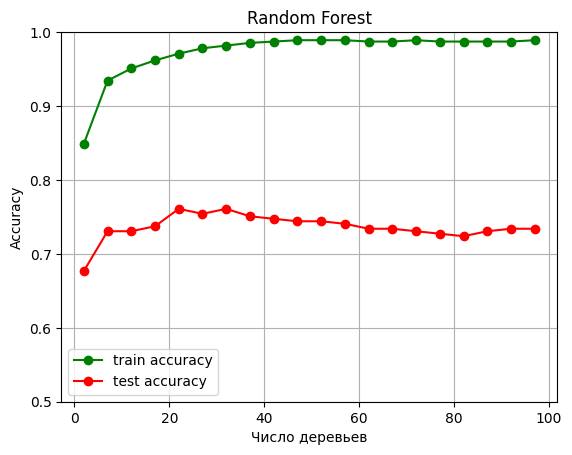

In [90]:
plt.plot(ensemble_sizes, acc_scores_rf_train, marker='o', label="train accuracy", c="g")
plt.plot(ensemble_sizes, acc_scores_rf_test, marker='o', label="test accuracy", c="r")
plt.title('Random Forest')
plt.xlabel('Число деревьев')
plt.ylabel('Accuracy')
plt.ylim((0.5, 1))
plt.legend()
plt.grid();

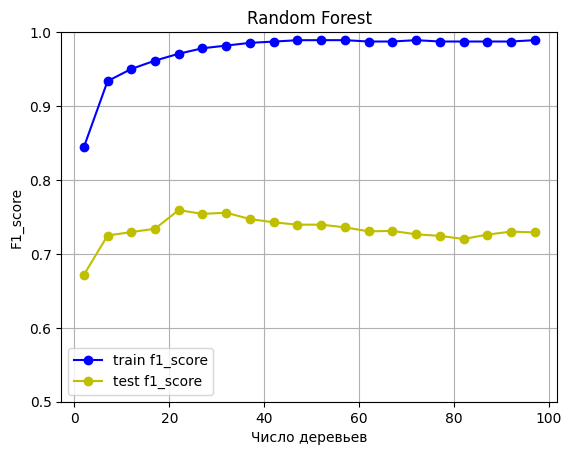

In [91]:
plt.plot(ensemble_sizes, f1_scores_rf_train, marker='o', label="train f1_score", c="b", )
plt.plot(ensemble_sizes, f1_scores_rf_test, marker='o', label="test f1_score", c="y")
plt.title('Random Forest')
plt.xlabel('Число деревьев')
plt.ylabel('F1_score')
plt.ylim((0.5, 1))
plt.legend()
plt.grid();

In [92]:
ensemble_sizes[np.where(np.array(acc_scores_rf_test) == max(acc_scores_rf_test))], max(acc_scores_rf_test)

(array([22, 32]), 0.7609427609427609)

In [93]:
acc_scores_rf_train[np.where(np.array(acc_scores_rf_test) == max(acc_scores_rf_test))[0][0]]

0.970856102003643

Оптимальное количество деревьев получилось 22 или 32 (accuracy на тестовой выборке равен 0.761). Модель всё ещё переобучена, но причина уже не в модели, а в маленькой размере выборки. Из-за этой же причины результаты бегингов и random forest-a не сильно отличаются.

#### 2.8. Learning curve
Your goal is to estimate, how does the model behaviour change with the increase of the `train` dataset size.

* Split the training data into 10 equal (almost) parts. Then train the models from above (Logistic regression, Desicion Tree, Random Forest) with optimal hyperparameters you have selected on 1 part, 2 parts (combined, so the train size in increased by 2 times), 3 parts and so on.

* Build a plot of `accuracy` and `f1` scores on `test` part, varying the `train` dataset size (so the axes will be score - dataset size.

* Analyse the final plot. Can you make any conlusions using it? 

In [94]:
train_sizes = np.linspace(0.1, 1.0, 10)

acc_lr_tr = []
acc_lr_te = []
f1_lr_tr = []
f1_lr_te = []

acc_tree_tr = []
acc_tree_te = []
f1_tree_tr = []
f1_tree_te = []

acc_rf_tr = []
acc_rf_te = []
f1_rf_tr = []
f1_rf_te = []

n_train = x_train_sc.shape[0]

for k in train_sizes:    
    x_sub = x_train_sc[:int(n_train * k)]
    y_sub = y_train[:int(n_train * k)]

    lr = LogisticRegression(**best_lr_params, multi_class='multinomial', solver='saga', tol=1e-3, max_iter=500)
    lr.fit(x_sub, y_sub)
    tr_pred_sub_lr = lr.predict(x_sub)
    te_pred_sub_lr = lr.predict(x_test_sc)
    acc_lr_tr.append(accuracy_score(y_sub, tr_pred_sub_lr))
    acc_lr_te.append(accuracy_score(y_test, te_pred_sub_lr))
    f1_lr_tr.append(f1_score(y_sub, tr_pred_sub_lr, average='macro'))
    f1_lr_te.append(f1_score(y_test, te_pred_sub_lr, average='macro'))

    tree = DecisionTreeClassifier(**best_tree_params, random_state=1)
    tree.fit(x_sub, y_sub)
    tr_pred_sub_tree = tree.predict(x_sub)
    te_pred_sub_tree = tree.predict(x_test_sc)
    acc_tree_tr.append(accuracy_score(y_sub, tr_pred_sub_tree))
    acc_tree_te.append(accuracy_score(y_test, te_pred_sub_tree))
    f1_tree_tr.append(f1_score(y_sub, tr_pred_sub_tree, average='macro'))
    f1_tree_te.append(f1_score(y_test, te_pred_sub_tree, average='macro'))

    rf = RandomForestClassifier(**best_params_rf, n_estimators=27, random_state=1, n_jobs=-1)
    rf.fit(x_sub, y_sub)
    tr_pred_sub_rf = rf.predict(x_sub)
    te_pred_sub_rf = rf.predict(x_test_sc)
    acc_rf_tr.append(accuracy_score(y_sub, tr_pred_sub_rf))
    acc_rf_te.append(accuracy_score(y_test, te_pred_sub_rf))
    f1_rf_tr.append(f1_score(y_sub, tr_pred_sub_rf, average='macro'))
    f1_rf_te.append(f1_score(y_test, te_pred_sub_rf, average='macro'))

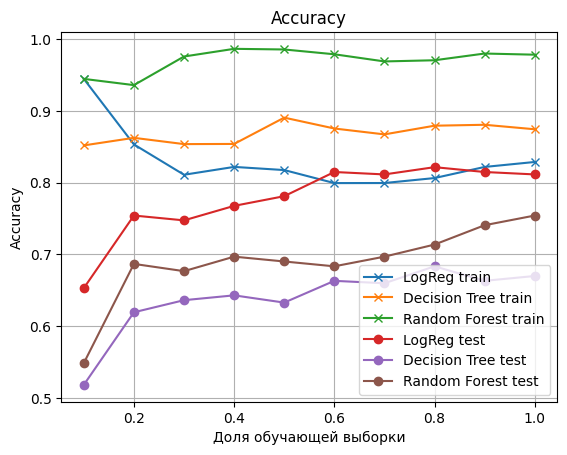

In [95]:
plt.figure()

plt.plot(train_sizes, acc_lr_tr, marker='x', label='LogReg train')
plt.plot(train_sizes, acc_tree_tr, marker='x', label='Decision Tree train')
plt.plot(train_sizes, acc_rf_tr, marker='x', label='Random Forest train')

plt.plot(train_sizes, acc_lr_te, marker='o', label='LogReg test')
plt.plot(train_sizes, acc_tree_te, marker='o', label='Decision Tree test')
plt.plot(train_sizes, acc_rf_te, marker='o', label='Random Forest test')

plt.title('Accuracy')
plt.xlabel('Доля обучающей выборки')
plt.ylabel('Accuracy')
plt.legend()
plt.grid();

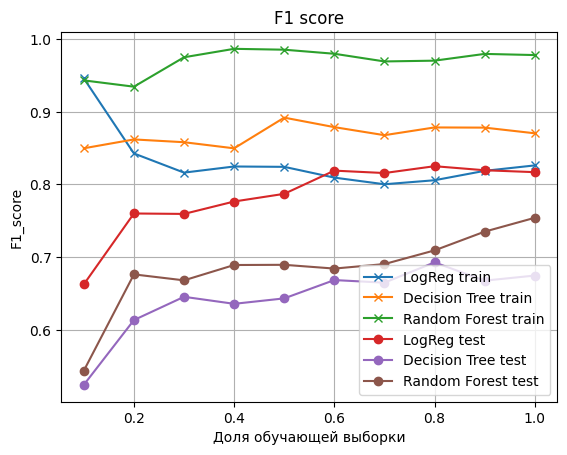

In [96]:
plt.figure()

plt.plot(train_sizes, f1_lr_tr, marker='x', label='LogReg train')
plt.plot(train_sizes, f1_tree_tr, marker='x', label='Decision Tree train')
plt.plot(train_sizes, f1_rf_tr, marker='x', label='Random Forest train')

plt.plot(train_sizes, f1_lr_te, marker='o', label='LogReg test')
plt.plot(train_sizes, f1_tree_te, marker='o', label='Decision Tree test')
plt.plot(train_sizes, f1_rf_te, marker='o', label='Random Forest test')

plt.title('F1 score')
plt.xlabel('Доля обучающей выборки')
plt.ylabel('F1_score')
plt.legend()
plt.grid();

Как и преполагалось в предыдущем пункте, проблема переобучения в маленькой размере выборки.

Из графика видно (Decision Tree и Logistic Regression), что точночть на тренировочной выборке уменьшается (немного), а на тестовой выборке увеличивается по мере увеличения размера выборки.

Что касается Random Forest, то точночть на тестовой выборке тоже увеличивается по мере увеличения размера выборки, а на тренировочной выборке более-менее стабильная (переобучена).

#### 2.9. Boosting
Your goal is to build a boosting ensemble using xgboost, CatBoost or lightgbm package.
Please, do not use the sklearn API for these models.

Find optimal number of decision trees in the boosting ensembe using grid search or other methods.
Please, explain your answer.

In [97]:
params = {"n_estimators": [30, 50, 70, 100, 150],
          "max_depth": [5, 7, 9],
          "learning_rate": [0.1, 0.3, 0.5],
         }

clf = xgb.XGBClassifier(subsample=0.9, colsample_bytree=0.9, 
                        random_state=1, n_jobs=-1,
                        tree_method="hist", device="cuda")

gs_xgb = GridSearchCV(estimator=clf, 
                      param_grid=params,
                      cv=5,
                      n_jobs=-1,
                      verbose=3)

gs_xgb.fit(x_train_sc, y_train_le)

best_xgb = gs_xgb.best_estimator_
best_params_xgb = gs_xgb.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [98]:
y_pred_tr = best_tree.predict(X_train)
y_pred = best_tree.predict(X_test)
y_proba = best_tree.predict_proba(X_test)

acc_tr = accuracy_score(y_train_le, y_pred_tr)
acc = accuracy_score(y_test_le, y_pred)
f1m = f1_score(y_test_le, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_le, y_proba, multi_class='ovr')

In [99]:
print("Best params:", best_params_xgb)
print(f"Train accuracy: {acc_tr:.3f}, Test accuracy: {acc:.3f}, F1_macro: {f1m:.3f}, ROC-AUC: {roc_auc:.3f}")

Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
Train accuracy: 0.865, Test accuracy: 0.687, F1_macro: 0.680, ROC-AUC: 0.848


Лучшие параметры получил (кросс-валидация - 5-fold)
- n_estimators = 30
- max_depth = 5
- learning_rate = 0.1

На тестовой выборке получил:
- accuracy = 0.687
- macro f1_score = 0.680
- ROC-AUC = 0.848

Тут особо не важен выборка нормализован или нет. Оба варианта дали одинаковый результат.

Модель переобучена (на тренировочной выборке accuracy больше, чем на тестовой выборке), но если попытаться избавиться от переобучения, то качество модели на тестовой выборке тоже сильно снижается.

### Выводы

- Лучшая модель - самая простая Logistic regression (Train accuracy: 0.829, Test accuracy: 0.811, F1_macro: 0.817).
- Результаты остальных моделей получились намного хуже. Они все переобучались. Причина в том, что датасет слишком маленький для сложных моделей, поэтому с задачой справилась самая простая модель.
- PCA. Больше 95% дисперсии достигается при 7 компонентам. Но при снижении размерности, естественно, ухудшаются результаты.
- Результаты каждого пункта более подробно привёл под каждым пунктом.